# Section 2 - Probabilistic machine learning
Basic concepts in prob ML and concepts relevant to diffusion model.

TODO:
* Variational inference
* Langevin sampling

In [13]:
import numpy as np
import matplotlib.pylab as plt
import torch
from torch.nn import NLLLoss
from sklearn import mixture
import scipy
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
np.random.seed(0)

## Outline
1. [Likelihood](#1-Likelihood)
2. [Discriminative vs generative models](#2-Discriminative-vs-generative-models)
3. [Parametric vs non-parametric inference](#3-Parametric-vs-non-parametric-inference)
4. [Why negative log likelihood](#4-Why-negative-log-likelihood)
5. [Assumptions on data](#5-Assumption-on-data)
6. [MLE](#6-Maximum-likelihood)
7. [MAP](#7-Maximum-a-posteriori)
8. [Bayesian estimation](#8-Bayesian-estimation)
9. [Inference](#9-Inference)
10. [Information theory](#10-Information-theory)
11. [KL-divergence](#11-Kullback-leibler-divergence)
12. [Cross-entropy](#12-Cross-entropy)
13. [Difference between KL-divergence and cross-entropy](#13-Difference-between-kl-divergence-and-cross-entropy)
14. [Evidence lower bound](#14-Evidence-lower-bound)
15. [Variational inference](#15-Variational-inference)
16. [Langevin sampling](#16-Langevin-sampling)
17. [Mixture of gaussians](#17-Mixture-of-gaussians)
18. [Expectation maximization](#18-Expectation-maximization)
19. [Bias and variance tradeoff](#19-Bias-and-variance-tradeoff)

## 1 Likelihood
Likelihood is an enigma to me, it just feels like people are throwing out the term likelihood left and right, which I don't understand. When I think of likelihood I think of the likelihood in the bayes' theorem $P(X|\theta)$, and that is the probability one wants to maximize if doing MLE for instance by finding the best $\theta$ parameters that gives the highest probability $P(X|\theta)$. Notice however that one can write this likelihood as a function of $\theta$, which makes it a likelihood function 

$$L(\theta, X) = P(X|\theta).$$

I seem to find different information on what exactly a likelihood function is, so I'm not sure what it truly is. [Here](https://stats.stackexchange.com/questions/2641/what-is-the-difference-between-likelihood-and-probability) is some clue as to what it might be, but [wiki](https://en.wikipedia.org/wiki/Likelihood_function) seems to have a definition for it. The distinction seems to be that if the function is regarded as a function of the data with a fix $\theta$, then it's a probability density/mass function, and as a function of $\theta$ with fixed data it's a likelihood function. 

## 2 Discriminative vs generative models
![](assets/disc%20vs%20gen.png)

The [image](https://i.sstatic.net/Xrmqg.png) taken from cs229 shows that discriminative models the class/target variable y directly given data x with a decision boundary, while generative models the flipped condition $P(x|y)$ and uses the prior as well if using MAP or an uninformative prior (usually ignored) if MLE. Just to make it clearer what it looks like in inference where you basically just pick the target y that makes the probability function in question result in the highest probability

$$f(x) = \underset{y}{\operatorname{argmax}} P(y | x),$$

where x is the new observation and y the target. For generative we have

$$f(x) = \underset{y}{\operatorname{argmax}} P(x | y)P(y) = \underset{y}{\operatorname{argmax}} P(x,y),$$

where x is the new observation and y the target.

What you do in the end with the estimation methods MAP/MLE/Bayes determines whether you will create a discriminative or generative model. For instance if creating a discriminative model you would train your model to directly learn $P(y|x, D, \theta)$, where D is the training dataset and $\theta$ the model parameters. For generative you would learn $P(x, y | D, \theta)$ which is the joint distribution and from this you can either decide if you want to infer the class given a new observation or generate a new data in both cases by using bayes, so generative is more flexible but more costly since you need to learn the joint. In this notebook for the inference part we will only predict the class y, but MAP and Bayes will be learning joint as part of their estimation tactic **(Not 100% sure here)**. MLE will learn the conditional and directly infer the class target.

## 3 Parametric vs non-parametric inference
**Parametric**
* Estimate $\theta$ (model parameters) using training data D
* Compute $P(y|x,\theta)$ to make inference, where y is target, x a new observation and $\theta$ model parameters

**Non-parametric**
* Estimate entire probability distribution of the model parameters given the training data $P(\theta|D)$
* Compute $P(y|x, \theta, D)P(\theta|D)$ by marginalizing out $\theta$ when making inference. Here D is the training data

MAP and MLE are **parametric** because they are point estimates that only estimates one set of model parameters. Bayes is **non-parametric**, because it learns the entire probability distribution of the parameters and uses it to make inference.

## 4 Why negative log likelihood
In practice when working with MLE/MAP/Bayes people use the negative log likelihood and the reasons for it are
* Avoid numerical underflows when multiplying lots of i.i.d data will quickly result in numbers being far below machine precision. For instance $log(0.5^1000000000) = 1000000000 * log(0.5) \approx -301029995.6\ldots$, which can be represented by a single precision 32-bit float
* Working with loss functions where we use MLE/MAP/Bayes to minimize the loss instead of maximizing, which is done by flipping the sign of the log likelihood making it negative
* Taking the derivative of the log likelihood is easier because of the logarithm laws that converts multiplication to summation instead. This makes it so we avoid using the product rule for derivatives eliminating lots of extra terms we don't have to work with
* Using negative log makes it more suitable to work with bits if needed for information theory for instance entropy

## 5 Assumption on data
It's usual to treat the training data as i.i.d, meaning independently identically distributed, so they are all independent and from the same distribution. This makes it easier to compute the joint in the numerator of the bayes, because then we will only need to multiply each marginal of data given model parameter and consequently with log we will only need to add.

## 6 Maximum likelihood
Maximum likelihood maximizes the likelihood (think of the likelihood in bayes) by finding the parameters for a distribution that fits well to the data. This is a point estimate, because it only finds the parameters that gives the highest probability of the parameters given the data. I think originally what you want is 

$$L(\theta, X) = P(\theta|X)$$

where X is the data and $\theta$ is the model parameters. But we can conveniently use baye's theorem here to flip the condition to make it easier to calculate the maximum point

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{P(X)} \propto P(X|\theta) $$

and in MLE we only care about the optimum points in the likelihood, the prior is set to uniform, so it's value doesn't depend on the parameter, which makes it a constant and thus is ignored (because it only scales the likelihood up, which doesn't change the location of max point). The proportional sign $\propto$ is to indicate a proportional relation, k * p, where k is some constant factor and p a probability distribution that we model. The objective then becomes

$$\theta_{opt} = \underset{\theta}{\operatorname{argmax}}L(X,\theta) = \underset{\theta}{\operatorname{argmax}}P(X|\theta)$$
 
What you do in practice I think is you pick a distribution beforehand to fit the data and try to maximize this $P(X|\theta)$ likelihood by finding the optimal parameters. If doing this by hand you would usually just take the derivative of the likelihood w.r.t the parameters and hope that it has a nice analytical form. Otherwise, use a computer. 

To illustrate what MLE does in the parameter space, it's a point estimate (pick out a single point as estimation), so it only finds the optimum parameters that gives the highest probability $P(X|\theta)$ and therefore $P(\theta|X)$

![](assets/mle.png)

The image shows the MLE for both discrete and continuous cases, i.e. when you are working with probability masses or probability densities. The y-axis is the likelihood $P(X|\theta)$, which is a function of $\theta$. Here the x-axis are the parameters $\theta$, and because we are only looking for the highest probability of the likelihood we therefore pick the parameters that results in this.
Note that because we are not using any priors to ground the estimates, that means MLE tends to overfit to the data if no other additional regularization is in place.

**Why drop the normalizing constant and prior in baye's theorem?**
\
Because the normalizing constant (the denominator in baye's theorem) just scales the likelihood, but since it's not dependent on the parameters, then it will not change the location of the maximum point. I've shown a simple example of that in the concepts notebook section 4 random variables, so you can take a look there if you want. Also, the normalizing constant is usually intractable if the model has lots of parameters. As for the prior MLE doesn't care about priors, I think that's just the way they defined it, because you also have MAP that is like MLE but with prior included. I think the point is that sometimes MAP can be more expensive than a simple MLE because you need some informative prior, which is not always easy to find. So instead with MLE we just choose not to deal with it at all, whether it's easy or hard to find it, and try to only maximize the likelihood instead. 

Here's a simple coin flip example, where we set the coin flip for heads to 60% and 40% for tails. We do 2 separate experiments, one where we repeat it 100 times and another only 5 times. This is to show the issues with overfitting when using MLE.

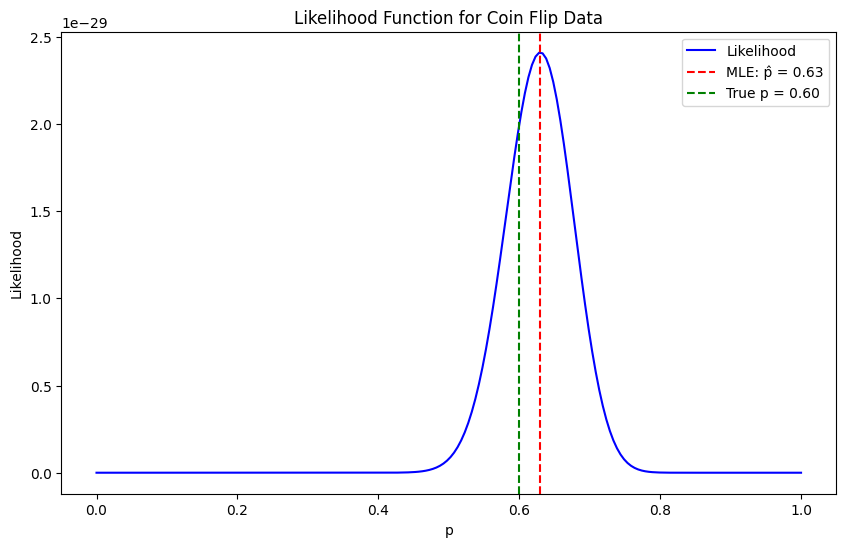

In [2]:
# Simulate coin flip data
np.random.seed(42)
n = 100  # total number of flips
true_p = 0.6  # true probability of heads
flips = np.random.binomial(1, true_p, n)
k = np.sum(flips)  # number of heads

# MLE estimate
p_hat = k / n

# Likelihood function
p_values = np.linspace(0, 1, 200)
likelihood = [p**k * (1 - p)**(n - k) for p in p_values]

# Plotting the likelihood function
plt.figure(figsize=(10, 6))
plt.plot(p_values, likelihood, label='Likelihood', color='blue')
plt.axvline(p_hat, color='red', linestyle='--', label=f'MLE: p̂ = {p_hat:.2f}')
plt.axvline(true_p, color='green', linestyle='--', label=f'True p = {true_p:.2f}')
plt.xlabel('p')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Coin Flip Data')
plt.legend()
plt.show();

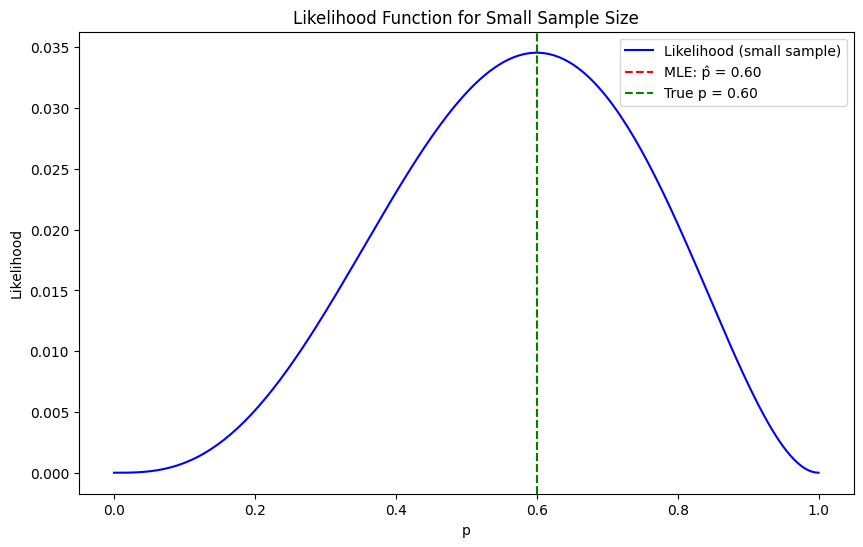

In [3]:
# Small sample size example
np.random.seed(42)
n_small = 5  # very few flips
flips_small = np.random.binomial(1, true_p, n_small)
k_small = np.sum(flips_small)

# MLE estimate for small sample size
p_hat_small = k_small / n_small

# Likelihood function for small sample size
likelihood_small = [p**k_small * (1 - p)**(n_small - k_small) for p in p_values]

# Plotting the likelihood function for small sample size
plt.figure(figsize=(10, 6))
plt.plot(p_values, likelihood_small, label='Likelihood (small sample)', color='blue')
plt.axvline(p_hat_small, color='red', linestyle='--', label=f'MLE: p̂ = {p_hat_small:.2f}')
plt.axvline(true_p, color='green', linestyle='--', label=f'True p = {true_p:.2f}')
plt.xlabel('p')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Small Sample Size')
plt.legend()
plt.show();

Here x-axis constitutes the different parameter values for the estimated p and y-axis is the likelihood value. In this case we can see that with more data (100) the $\mu$ doesn't overfit as much as with fewer data (5).

If we were to do this by hand we would first have to define the likelihood and then take the derivative of it w.r.t to the parameter p. Since this is a coin flip we use a bernoulli distribution, where p represents the probability of heads. Each trial is indepedent so we get

$$L(X, p) = P(X|p) = p^{\textstyle n_{\text{head}}} (1-p)^{\textstyle n_{\text{tail}}}$$

Since our goal is to find the optimum parameter p̂

$$p̂ = \underset{p}{\operatorname{argmax}}P(X|p),$$

we simply take the derivative of $P(X|p)$ w.r.t p, set it to zero and solve for p.

$$
\begin{align}
0 &= \dfrac{d}{dp}P(X|p) \\
&= \dfrac{d}{dp} p^{\textstyle n_{\text{head}}}(1-p)^{\textstyle n_{\text{tail}}} \\
&= n_{\text{head}}p^{\textstyle n_{\text{head}} - 1} - n_{\text{tail}}p^{\textstyle n_{\text{head}}}(1-p)^{\textstyle n_{\text{tail}} - 1}
\end{align}
$$

This is a general formula for the derivative of the likelihood w.r.t to the parameter p. If we just insert the $n_{\text{head}}$ and $n_{\text{tail}}$ and solve for p that will be our solution. I will skip because lazy.

From the experiment with the coin flips we could see that with more data MLE becomes less overfit. To see this we can observe another simple example with a gaussian distribution where we use MLE to estimate the model parameters $\mu$ and $\sigma$.
Here's a simple example with data generated from a gaussian with 5 mean and std 2.

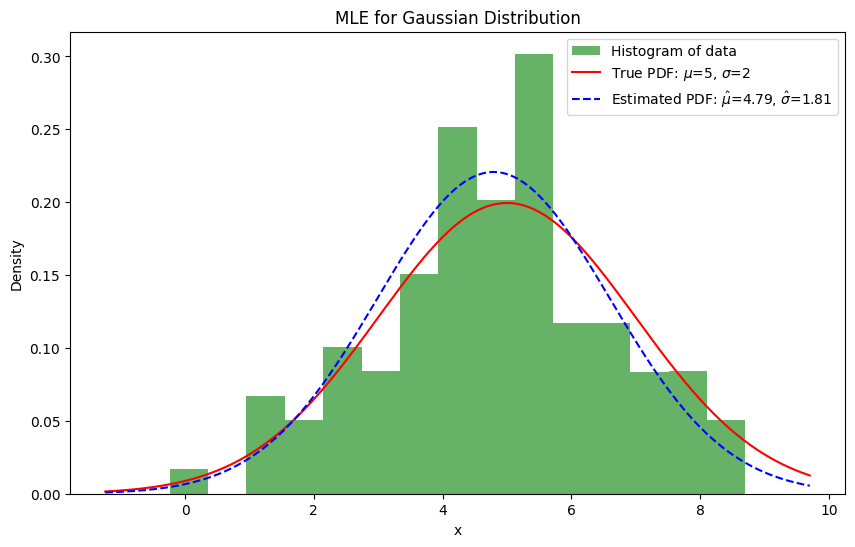

In [4]:
# Simulate data from a Gaussian distribution
np.random.seed(42)
true_mu = 5
true_sigma = 2
n = 100
data = np.random.normal(true_mu, true_sigma, n)

# MLE estimates
mu_hat = np.mean(data)
sigma_hat = np.std(data, ddof=0)

# Visualization
x = np.linspace(min(data) - 1, max(data) + 1, 1000)
true_pdf = (1 / (true_sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - true_mu) / true_sigma) ** 2)
estimated_pdf = (1 / (sigma_hat * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_hat) / sigma_hat) ** 2)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, density=True, alpha=0.6, color='g', label='Histogram of data')
plt.plot(x, true_pdf, 'r-', label=f'True PDF: $\mu$={true_mu}, $\sigma$={true_sigma}')
plt.plot(x, estimated_pdf, 'b--', label=f'Estimated PDF: $\hat{{\mu}}$={mu_hat:.2f}, $\hat{{\sigma}}$={sigma_hat:.2f}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show();

The blue curve is the gaussian with the estimated model parameters and the red curve is the true gaussian distribution. We can see that it's not too far off, although a perfect match would have not been desirable anyways to avoid overfitting.
So here we are trying to find the optimal parameters $\mu$ and $\sigma$ for a univariate gaussian distribution. The data is originally generated from a gaussian with mean 5 and std 2 and our model approximates it. One can also do this analytically and the derivations would have looked like this

$$L(\mu, \sigma | x_1, x_2, \ldots, x_n) = \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x_i - \mu)^2}{2\sigma^2} \right)$$

We choose to work with the log likelihood to make computations easier

$$
\begin{align}
\ell(\mu, \sigma | x_1, x_2, \ldots, x_n)
&= \log L(\mu, \sigma | x_1, x_2, \ldots, x_n) \\
&= \sum_{i=1}^{n} \left( -\frac{1}{2} \log(2 \pi \sigma^2) - \frac{(x_i - \mu)^2}{2\sigma^2} \right) \\
&= -\frac{n}{2} \log(2 \pi) - \frac{n}{2} \log(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2 \\ 
\end{align}
$$

Now we take the derivative w.r.t $\mu$ and $\sigma$

Solving for $\mu$
$$
\frac{\partial \ell}{\partial \mu} = \frac{1}{\sigma^2} \sum_{i=1}^{n} (x_i - \mu) = 0 \implies \hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

Solving for $\sigma$
$$
\frac{\partial \ell}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} \sum_{i=1}^{n} (x_i - \mu)^2 = 0 \implies \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{\mu})^2
$$

Now we have general formulas to compute the exact optimal mean and sigma. If we just input the data we will get the optimal $\mu$ and $\sigma$ which solves

$$\theta_{opt} = \underset{\theta}{\operatorname{argmax}}L(X|\theta),$$

where $\theta$ is our model parameters. 

**Bias in ML**
\
To demonstrate the bias in the estimated model parameters $\mu$ and $\sigma$ we have

$$\begin{align}
E[\mu_{\text{ML}}] 
&= \dfrac{1}{N}\sum_{i=1}^{N}E[x_i] \\
&= \dfrac{1}{N}N\mu \\
&= \mu
\end{align}
$$

So the mean is unbiased as $E[\mu_{\text{ML}}] = E[X] = \mu$. Now on to the variance

$$\begin{align}
E[\sigma_{\text{ML}}] 
&= \dfrac{1}{N}\sum_{i=1}^{N}E[(x_i - \mu_{\text{ML}})^2] \\
&= \{\text{Use } E[x^2] = v[x] - E[x]^2 \text{ and set } a = (x_i - \mu_{\text{ML}}) \} \\
&= \dfrac{1}{N}\sum_{i=1}^{N}V[a] - E[a]^2 \\
&= \dfrac{1}{N}\sum_{i=1}^{N}V[x_i - \mu_{\text{ML}}] - E[x_i - \mu_{\text{ML}}]^2 \\
&= \{E[x_i - \mu_{\text{ML}}]^2 = (\mu - \mu)^2 = 0 \text{ and } V[x_i] = \sigma^2, V[\mu_{\text{ML}}] = \dfrac{1}{N} \sigma^2 \} \\
&= \dfrac{1}{N}\sum_{i=1}^{N}\sigma^2 - \dfrac{\sigma^2}{N} \\
&= \dfrac{1}{N}\sum_{i=1}^{N}\dfrac{N\sigma^2 - \sigma^2}{N} \\
&= \dfrac{N\sigma^2 - \sigma^2}{N} \\
&= \dfrac{\sigma^2(N-1)}{N} \\
&= \dfrac{N-1}{N}\sigma^2 \\
\end{align}
$$

So we can see here that the estimated variance is biased with factor $\dfrac{N-1}{N}$. To understand why overfitting reduces as we use more data for MLE is because the ratio $\dfrac{N-1}{N}$ will approach 1 for bigger data sizes and thus the bias will have a smaller effect, almost having no effect when the data is extremely big. In the limit $N \to \infty$ the variance of the MLE approaches the true variance. However, the bias might look different for other types of distributions and might still be prevalent even with bigger data in the presence of more complex models (more parameters). So using regularization techniques might be more important in those cases, since only relying on the data size as regularization might not be enough. However, it's safe to say that for a univariate gaussian distribution using a bigger data should suffice to reduce the bias.

**The ML revelation - mean squared error**
\
Lastly, one can show that maximizing $P(y|x, w, \sigma^2)$ with ML is the same thing as minimizing the mean squared error, which is very interesting. Let the model be 

$$y = w^Tx + \epsilon,$$

and the noise gaussian distributed

$$\epsilon \sim \mathcal{N}(0, \sigma^2),$$

then Y will be gaussian distributed as well

$$Y \sim \mathcal{N}(w^Tx, \sigma^2).$$

Now with ML the objective is to directly maximize $P(y|x,w,\sigma^2)$, which by the way shows why ML is a discriminative method.

$$
\begin{align}
logP(y|x,w,\sigma^2) 
&= log \prod_i P(y_i|x_i,w,\sigma^2) \\
&= \sum_i logP(y_i|x_i,w,\sigma^2) \\
&= \sum_i log\left[ \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{\textstyle \dfrac{(y_i - w^Tx_i)^2}{2\sigma^2}} \right] \\
&= \sum_i - \dfrac{1}{2}log(2\pi\sigma^2) - \dfrac{(y_i - w^Tx_i)^2}{2\sigma^2} \\
&\implies \underset{w}{\operatorname{argmax}}P(y|x, w, \sigma^2) = \text{ } \underset{w}{\operatorname{argmin}}\sum_i (y_i - w^Tx_i)^2
\end{align}
$$

The factors $- \dfrac{1}{2}log(2\pi\sigma^2)$ and $- \dfrac{1}{2\sigma^2}$ doesn't affect the location of the optimum weights $w$ for the minimization of the loss function, because they don't depend on the weights, they are constants. Therefore, we can omit them completely. What we are then left with is the mean squared error $\sum_i (y_i - w^Tx_i)^2$.
Now we can see clearly that maximizing $P(y|x,w,\sigma^2)$ is the **same as minimizing the mean squared error**! This means that everytime you are using the mean squared error as the loss function with some model (where the prediction is your model prediction so in the example above we would replace the $w^Tx_i$ with our model prediction), what you are essentially doing is performing maximum likelihood on the model that is assumed to have gaussian noise with zero mean and variance $\sigma^2$. 

## 7 Maximum a posteriori
This is like MLE but with prior

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{P(X)} \propto P(X|\theta)P(\theta)$$

$$L(\theta|X) = P(X|\theta)P(\theta)$$

Our objective becomes

$$\theta_{opt} = \underset{\theta}{\operatorname{argmax}}P(X|\theta)P(\theta)$$ 

where our objective is to find the parameters $\theta$ that maximizes the posterior $P(\theta|X)$ by instead maximizing the joint $P(X|\theta)P(\theta)$. Distrbutions for both the likelihood $P(X|\theta)$ and the prior $P(\theta)$ has to be determined beforehand.

No time, so I will skip going through this mathematically, but here's a code example with both MLE and MAP to show the difference.

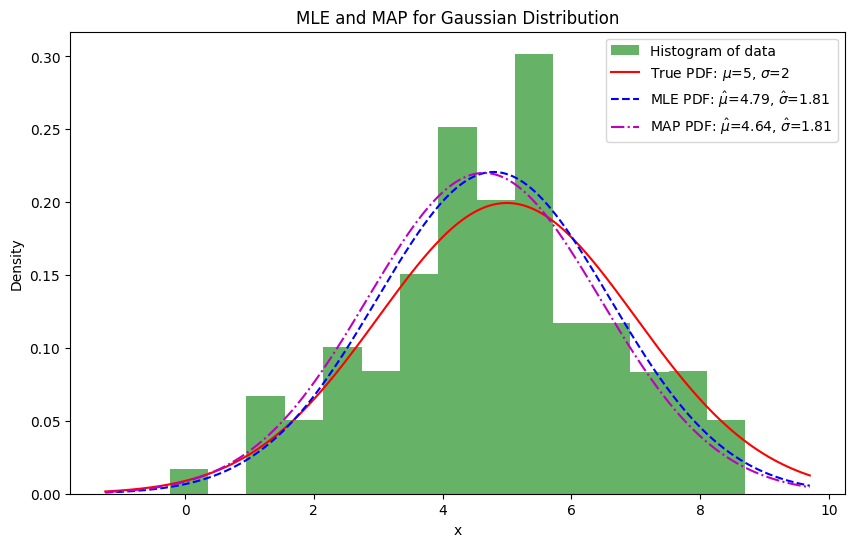

In [5]:
# Simulate data from a Gaussian distribution
np.random.seed(42)
true_mu = 5
true_sigma = 2
n = 100
data = np.random.normal(true_mu, true_sigma, n)

# Hyperparameters for the priors
mu_0 = 0
tau2 = 1
alpha = 1
beta = 1

# MLE estimates (used for comparison)
mu_mle = np.mean(data)
sigma2_mle = np.var(data, ddof=0)

# MAP estimates
# Update the priors with the data
mu_n = (mu_0 / tau2 + n * mu_mle / sigma2_mle) / (1 / tau2 + n / sigma2_mle)
tau2_n = 1 / (1 / tau2 + n / sigma2_mle)
alpha_n = alpha + n / 2
beta_n = beta + 0.5 * np.sum((data - mu_mle) ** 2)

# Posterior mean and variance
mu_map = mu_n
sigma2_map = beta_n / (alpha_n - 1)

# Visualization
x = np.linspace(min(data) - 1, max(data) + 1, 1000)
true_pdf = (1 / (true_sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - true_mu) / true_sigma) ** 2)
estimated_pdf_mle = (1 / (np.sqrt(sigma2_mle) * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_mle) / np.sqrt(sigma2_mle)) ** 2)
estimated_pdf_map = (1 / (np.sqrt(sigma2_map) * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_map) / np.sqrt(sigma2_map)) ** 2)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, density=True, alpha=0.6, color='g', label='Histogram of data')
plt.plot(x, true_pdf, 'r-', label=f'True PDF: $\mu$={true_mu}, $\sigma$={true_sigma}')
plt.plot(x, estimated_pdf_mle, 'b--', label=f'MLE PDF: $\hat{{\mu}}$={mu_mle:.2f}, $\hat{{\sigma}}$={np.sqrt(sigma2_mle):.2f}')
plt.plot(x, estimated_pdf_map, 'm-.', label=f'MAP PDF: $\hat{{\mu}}$={mu_map:.2f}, $\hat{{\sigma}}$={np.sqrt(sigma2_map):.2f}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('MLE and MAP for Gaussian Distribution')
plt.legend()
plt.show();

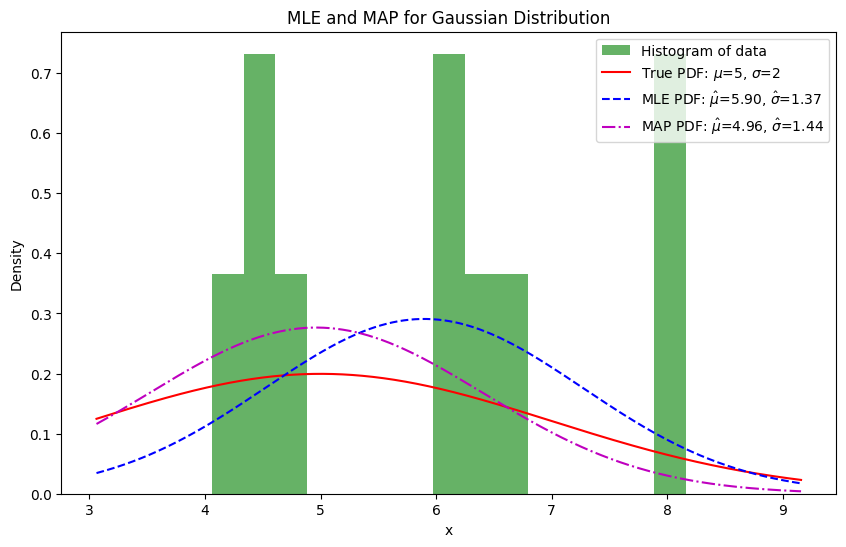

In [6]:
# Simulate data from a Gaussian distribution
np.random.seed(42)
true_mu = 5
true_sigma = 2
n = 10
data = np.random.normal(true_mu, true_sigma, n)

# Hyperparameters for the priors
mu_0 = 0
tau2 = 1
alpha = 1
beta = 1

# MLE estimates (used for comparison)
mu_mle = np.mean(data)
sigma2_mle = np.var(data, ddof=0)

# MAP estimates
# Update the priors with the data
mu_n = (mu_0 / tau2 + n * mu_mle / sigma2_mle) / (1 / tau2 + n / sigma2_mle)
tau2_n = 1 / (1 / tau2 + n / sigma2_mle)
alpha_n = alpha + n / 2
beta_n = beta + 0.5 * np.sum((data - mu_mle) ** 2)

# Posterior mean and variance
mu_map = mu_n
sigma2_map = beta_n / (alpha_n - 1)

# Visualization
x = np.linspace(min(data) - 1, max(data) + 1, 1000)
true_pdf = (1 / (true_sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - true_mu) / true_sigma) ** 2)
estimated_pdf_mle = (1 / (np.sqrt(sigma2_mle) * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_mle) / np.sqrt(sigma2_mle)) ** 2)
estimated_pdf_map = (1 / (np.sqrt(sigma2_map) * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_map) / np.sqrt(sigma2_map)) ** 2)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=15, density=True, alpha=0.6, color='g', label='Histogram of data')
plt.plot(x, true_pdf, 'r-', label=f'True PDF: $\mu$={true_mu}, $\sigma$={true_sigma}')
plt.plot(x, estimated_pdf_mle, 'b--', label=f'MLE PDF: $\hat{{\mu}}$={mu_mle:.2f}, $\hat{{\sigma}}$={np.sqrt(sigma2_mle):.2f}')
plt.plot(x, estimated_pdf_map, 'm-.', label=f'MAP PDF: $\hat{{\mu}}$={mu_map:.2f}, $\hat{{\sigma}}$={np.sqrt(sigma2_map):.2f}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('MLE and MAP for Gaussian Distribution')
plt.legend()
plt.show();

First experiment shows for 100 samples and the second shows for 10 samples. This is to demonstrate the effect of large and smaller dataset on MLE vs MAP.
We can see that for more data MAP and MLE seems to be close to each other, while for lesser data the prior starts to kick in having a bigger influence on the MAP estimation of the parameters. According to [wiki](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) the prior acts as a regularizer and for certain distributions one can very elegantly show how it manifests as a regularizer, for instance if we consider a linear regression model again 

$$y = w^Tx + \epsilon$$

With gaussian noise

$$\epsilon \sim \mathcal{N}(0, \sigma_Y^2)$$

and gaussian distributed weights, because we have a prior on the weights now as opposed to when we used MLE that didn't care about the prior

$$w \sim \mathcal{N}(0, \sigma_w^2I_D)$$

Then using MAP to maximize the posterior one can show (I will skip the derivations) that the posterior $P(w|y,x)$ can be expressed as a mean squared error loss function, where we instead minimize it

$$\underset{w}{\operatorname{argmin}}\left[ \underbrace{\textcolor{red}{\dfrac{1}{2\sigma_Y^2}\sum_{n=1}^N (y_n - w^Tx_n)^2}}_{\textcolor{red}{\text{fit the data (ML)}}} + \underbrace{ \textcolor{green}{\dfrac{1}{2\sigma_W^2}w^Tw}}_{\textcolor{green}{\text{keep w short}}} \right]$$

where the red constitutes what you would get with just MLE and the green constitutes the extra regularizing term you get with MAP in addition to the red part. In this case the green expression is the [L2-norm](https://mathworld.wolfram.com/L2-Norm.html) (keep w low values). However, as mentioned the form of the regularizer differs depending on what distributions are assumed. In the case the weights came from a laplace distrubtion the regularizer would have taken the form of a [L1-norm](https://mathworld.wolfram.com/L1-Norm.html) (keep the w simple by eliminating irrelvant ones) instead. 

## 8 Bayesian estimation
It's very similar to MAP, except it's not a point estimate anymore, because it divides the MAP with a normalizing constant to make the posterior a proper probability distribution. It computes the entire distribution of the parameters $P(\theta|X)$ and uses this in inference to compute a weighted average of the prediction $P(y|x, \theta)$ where $\theta$ is the model parameters, x the new observation, y the target/class, and the weights are given by the probability of the parameters $P(\theta|X)$, where X is the training data. So bayesian estimation takes into account how likely parameters are, it doesn't just find the parameters that gives the highest probability for the likelihood because those parameters can be very unlikely. Remember, just because the likelihood is maximized by a set of parameters doesn't mean that those set of parameters are likely to occur i.e. $P(\theta)$ might be low. To give intuition as to why some parameters can be unlikely consider the case of ML, where one can make the likelihood arbitrarily large to overfit the data. An alternative situation with regression overfitting also shows the implausibility of the parameters that causes the fit.

![](assets/ml_overfit.png)
![](assets/regression_overfit.png)

In both cases one would think that the parameters are probably not very likely. So it would be prudent to take into consideration the probability of the parameters in order to capture some kind of way of measuring the uncertainty we have about the choices of our models. Each parameter setting constitutes one possible model.
For the bayesian estimation of the model parameters we have for the continuous case

$$P(\theta | X) = \dfrac{P(X|\theta)P(\theta)}{P(X)} = \dfrac{P(X|\theta)P(\theta)}{\int P(X|\theta)P(\theta) \,d\theta}$$

so we can see that the posterior we get is an entire distribution over the parameters and not just a point estimate anymore. This means that in inference we will use this posterior as the prior, multiply it with the likelihood (our predicted class given parameters and new observation) and marginalize out all the parameters by integrating (for continuous case) to get a weighted average of the predicted class. This shows clearly that we pay much more attention to how likely different parameters are. What's interesting about this approach is that we are basically considering all possible models and weighting them by their probability of occurring. Therefore, incorporating this idea into the computation of the prediction is the reason why the prediction becomes a weighted sum. The inference looks like this

$$P(y|x,D) = \int_{\theta \in \Theta} P(y|x, \theta)P(\theta|D)$$

The bayesian treatment of the model parameter estimation makes it so that very simple models as well as very complex models have in general low probability of occurring and therefore are given lower weights (importance) to influcene, whereas intermediate models have a bigger influence on the inference. There is however a big drawback with bayesian inference and estimation in a DL setting. Usually DL models are big with lots of parameters, so trying to marginalize over these number of parameters is often not possible. So in practice people use MLE preferably with lots of data with regularization techniques rather than applying bayesian estimation on very small models. 

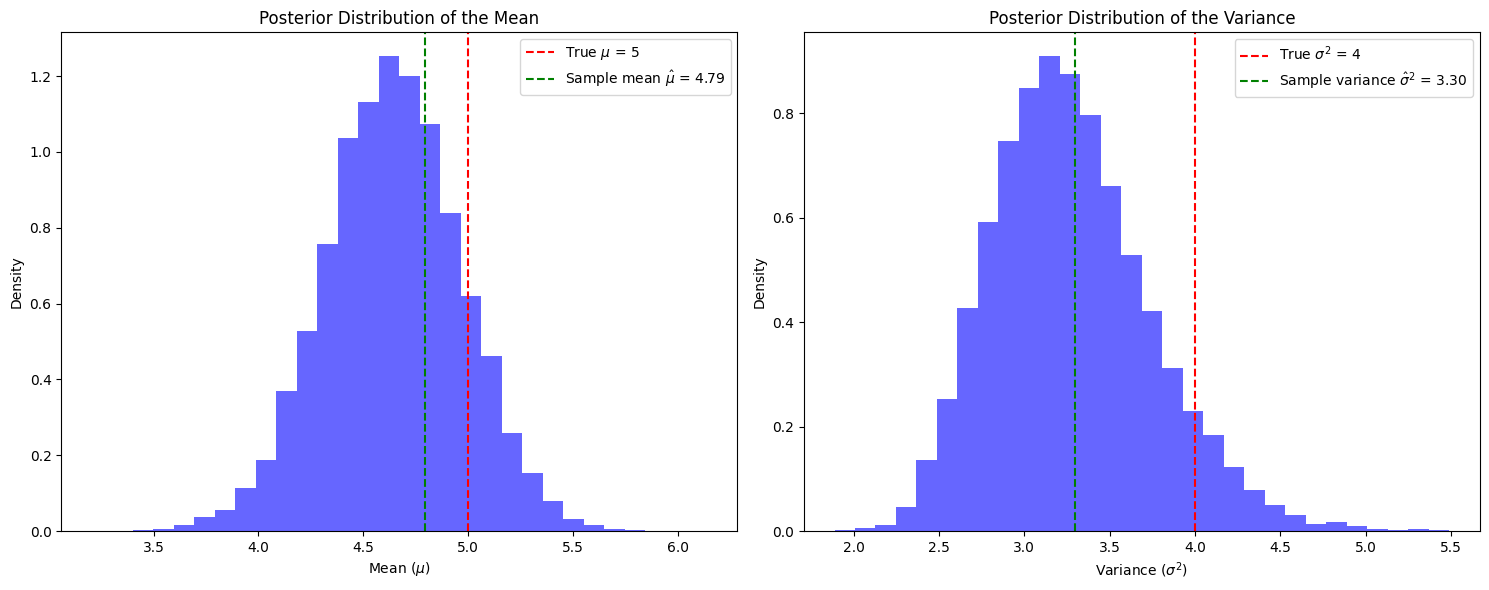

In [7]:
from scipy.stats import norm, invgamma

# Simulate data from a Gaussian distribution
np.random.seed(42)
true_mu = 5
true_sigma = 2
n = 100
data = np.random.normal(true_mu, true_sigma, n)

# Hyperparameters for the priors
mu_0 = 0
tau2 = 1
alpha = 1
beta = 1

# Update the priors with the data
n = len(data)
x_bar = np.mean(data)
s2 = np.var(data, ddof=1)

# Posterior hyperparameters
mu_n = (mu_0 / tau2 + n * x_bar / s2) / (1 / tau2 + n / s2)
tau2_n = 1 / (1 / tau2 + n / s2)
alpha_n = alpha + n / 2
beta_n = beta + 0.5 * np.sum((data - x_bar) ** 2)

# Draw samples from the posterior distributions
n_samples = 10000
posterior_sigma2_samples = invgamma.rvs(alpha_n, scale=beta_n, size=n_samples)
posterior_mu_samples = norm.rvs(mu_n, np.sqrt(tau2_n * posterior_sigma2_samples), size=n_samples)

# Visualization of the posterior distributions
plt.figure(figsize=(15, 6))

# Posterior distribution of the mean
plt.subplot(1, 2, 1)
plt.hist(posterior_mu_samples, bins=30, density=True, alpha=0.6, color='b')
plt.axvline(true_mu, color='r', linestyle='--', label=f'True $\mu$ = {true_mu}')
plt.axvline(x_bar, color='g', linestyle='--', label=f'Sample mean $\hat{{\mu}}$ = {x_bar:.2f}')
plt.xlabel('Mean ($\mu$)')
plt.ylabel('Density')
plt.title('Posterior Distribution of the Mean')
plt.legend()

# Posterior distribution of the variance
plt.subplot(1, 2, 2)
plt.hist(posterior_sigma2_samples, bins=30, density=True, alpha=0.6, color='b')
plt.axvline(true_sigma**2, color='r', linestyle='--', label=f'True $\sigma^2$ = {true_sigma**2}')
plt.axvline(s2, color='g', linestyle='--', label=f'Sample variance $\hat{{\sigma}}^2$ = {s2:.2f}')
plt.xlabel('Variance ($\sigma^2$)')
plt.ylabel('Density')
plt.title('Posterior Distribution of the Variance')
plt.legend()

plt.tight_layout()
plt.show();

Here the likelihood is gaussian and prior is normal inverse gamma, since these are [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution) to each other we can combine them into another proportional normal inverse gamma where the proportion is described by some scaling factor. So the posterior is a normal inverse gamma and what we see in the graph is a distribution of the model parameters $\mu$ and $\sigma^2$. What we end up getting is therefore a distribution of the model parameters and not just a point estimate (a specific $\mu$ and $\sigma^2$).

**I'm gonna be honest, I'm not 100% sure the plots are correct, because we are working with gamma inverse normal distributions, and I don't know if they are supposed to look like that for the histograms?**  

## 9 Inference
Inference in this case means predicting the target variable, for instance predicting class given a new observation input to a model. So there's a distinction between inference and estimation. Estimation is the phase when we estimate the model parameters, i.e. train the model. Inference is at test time and all other situations after training is done.
\
**Maximum likelihood inference**
\
$\underset{\theta}{\operatorname{argmax}}P(y|x, \theta, X) = f(x)$, where f(x) is the already trained model, so it only needs an input to output something. **(I think this is the case for inference of ML)**
\
**Maximum a posteriori inference**
\
$\underset{\theta}{\operatorname{argmax}}P(y|x, \theta, X) = f(x)$, where f(x) is trained once again, but the way it's trained is by introducing a prior in addition to the likelihood.
\
**Bayesian inference**
\
$P(y|x,D) = \int_{\theta \in \Theta} P(y|x, \theta)P(\theta|D)$, this one is interesting because you never get a point estimate, so your "model" is the posterior distribution of the parameters. This is the one you use everytime you have a new observation and want to make a prediction, you need to marginalize over all the parameters so you end up with a weighted average of the prediction. Downside with this is that it's costly if the model is big.

## 10 Information theory
Information theory is an entire field in it of itself, and we only need a very small fraction of it for deep learning. I will only cover the most essential concepts presented in [d2l](https://classic.d2l.ai/chapter_appendix-mathematics-for-deep-learning/information-theory.html#kullbackleibler-divergence).

\
**Self-information**
\
Let's start with self-information.

$$-\log_b(p)$$ 

where b is the log base and p is some probability. Usually it's expressed as bits with log base 2 or as nats with log base e (which is equivalent to ln), but there are other units of information possible.
If we use bits units, I usually think of the expression as the amount of bits $log_2(p)$ needed to encode something, for instance if we have 8 possible outcomes (each row in the table below is one outcome) of something then we would need $log_2(8) = 3$ bits to encode all the 8 outcomes because $2^3=8$.
$$
\begin{array}{|c|c|c|}
\hline
A & B & C \\
\hline
0 & 0 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0 \\
0 & 1 & 1 \\
1 & 0 & 0 \\
1 & 0 & 1 \\
1 & 1 & 0 \\
1 & 1 & 1 \\
\hline
\end{array}
$$ 

In a probability setting we have $0 \leq P(X=x) \leq 1$ which makes the $log_2P(X)$ negative. To combat this we instead flip it by multiplying it with -1. This gives us $-log_2P(X=x)$, which conveniently is equal to $log_2\left(\frac{1}{P(X=x)}\right)$, which is the bits needed to encode the total outcomes $\frac{1}{P(X=x)}$. For instance if we have $P(X=a) = 1/4$, then the total outcomes must be $\dfrac{1}{\dfrac{1}{4}} = 4$, and the number of bits to encode this would be $log_2(4) = 2$. This intuitive idea of encoding outcomes or information is called [self-information](https://en.wikipedia.org/wiki/Information_content#Definition).

\
**Entropy**
\
The definition of entropy uses self-information to calculate the average (expected value) bits needed to encode the information. Entropy distinguishes between discrete and continuous random variables. Entropy is generally defined as

$$H(X) = -E_{x \sim P}[logP(x)]$$

and for discrete case we have 

$$H(X) = -\sum_i p_i\log p_i$$

where $p_i = P(X_i)$. For the continuous case we have

$$H(X) = -\int_x p(x) log(x) \,dx.$$

There are different interpretations of entropy. Personally I go with uncertainty or surprise, the higher the entropy is the higher uncertainty/surprise. For instance a coin flip with 50% outcome would have a very high entropy, because one would be very uncertain or surprised about the outcome of the coin flip because it could be either head or tail. However, if the coin was instead 99% head and 1% tail, then there wouldn't be much uncertainty of the outcome, because 99 out of 100 times it should result in heads statistically. Mathematically we can interpret it as the average self-information from observing each output.

**Joint entropy**
\
As one would expect it's almost the same as entropy but for the probability distribution we choose the joint

$$H(X,Y) = -E_{(x,y) \sim P}[\log P_{X,Y}(x,y)]$$

where we have for the discrete and continuous case

$$H(X,Y) = -\sum_x \sum_y P_{X,Y}(x,y) \log p_{X,Y}(x,y)$$

$$H(X,Y) = -\int_{x,y} P_{X,Y}(x,y) \log p_{X,Y}(x,y) \,dxdy$$

where $P_{X,Y}(x,y)$ is the joint probability of the random variables X and Y.

We can interpret it as the total randomness in X and Y. From this are some special cases
* $X=Y$ then we have $H(X,Y) = H(X) = H(Y)$
* X independent Y gives $H(X,Y) = H(X) + H(Y)$

Additionally, there's from this we get an important relationship

$$H(X), H(Y) \leq H(X,Y) \leq H(X) + H(Y)$$

**Conditional entropy**
\
The definition is

$$H(Y|X) = -E_{(x,y) \sim P}[\log P(y|x)]$$

and for the discrete and continuous cases

$$H(Y|X) = -\sum_x \sum_y P(x,y) \log p(y|x)$$

$$H(Y|X) = -\int_x\int_y P(x,y) \log p(y|x) \,dxdy.$$

And there are some interesting relationships with conditional entropy

$$H(Y|X) = H(X,Y) - H(X)$$

the interpretation of this is that $H(Y|X)$ gives us the information in Y, which is not in X. Essentially what has been done here is we have taken the total information in both X and Y and subtracted it with the total information in X, and what we are left with then is the information only contained in Y that is not in X because we just subtracted it away.


**Mutual information**
\
Mutual information is defined as 

$$I(X,Y) = H(X,Y) - H(Y|X) - H(X|Y).$$

It's like the joint probability equivalent of venn diagrams. However, the joint entropy is **not** the counterpart of joint probability in venn diagrams, although one could find similarities. It's mostly because the way to compute this quantity is different than computing joint probability $P(X,Y) = P(X|Y)P(Y) = P(Y|X)P(X)$. Entropy is a little different in that sense. This is best described with an entropy venn diagram

![](assets/mutual_information.png)

As can be seen the middle part that looks like what we usually see as the joint probability in an event venn diagram. This therefore, albeit it's computed differently than joint probability, constitutes in the same way the information shared between the two random variables X and Y. To arrive at the definition at the start of this little section is by thinking of starting with the joint entropy which is the entire diagram, that is the total randomness or information contained in both X and Y together and then remove the parts that are not shared such as $H(Y|X)$ (only information contained in Y but not in X) and $H(X|Y)$ (information contained in X but not in Y). What remains should then be the total shared information in X and Y. Expanding and simplifying the definition gives us

$$I(X,Y) = E_XE_Y\left[P_{X,Y}(x,y) \log \dfrac{P_{X,Y}(x,y)}{P_X(x)P_Y(y)}\right].$$

The log term inside mutual information $\log \dfrac{P_{X,Y}(x,y)}{P_X(x)P_Y(y)}$ is called pointwise mutual information and gives a measure of how surprised/uncertain one is to see the joint outcome occur compared to random chance (if they were independent, which is denoted by the denominator). The larger the ratio is the more surprised/uncertain we are to witness the occurrence of them, and in turn it means they have a higher frequency of occurring than random chance. This also means that the entire mutual information can be interpreted as the average surprise/uncertainty we would for X and Y occurring at the same time compared to if they were independent.

Some interesting relationships arises from this where we can express the mutual information in different forms. It helps alot to understand these by just looking at the venn diagram.
* $H(X) - H(X|Y)$, subtracting the information contained in only X and not in Y from the total information in X will yield the information shared between X and Y
* $H(Y) - H(Y|X)$, same situation as above but reversed
* $H(X) + H(Y) - H(X,Y)$, this is very similar to when doing $A U B$ in a venn diagram with events A and B, then you would need to subtract away the extra $A n B$ that is added twice because of the OR operation. It's exactly the same idea, we will be adding the mutual information twice simply because we are adding H(X) and H(Y), so we need to therefore subtract away the double mutual information $H(X,Y)$ once.

Mutual information is more general than covariance, as it's able to capture both linear and non-linear relationships between the random variables.

**Properties of mutual information**
* Symmetric $I(X,Y) = I(Y,X)$
* Non-negative $I(X,Y) \geq 0$
* $I(X,Y) = 0$ means X and Y are independent. This is better than covariance, where zero covariance doesn't necessarily imply independence between the random variables
* If X is invertible function of Y then $I(X,Y) = H(Y) = H(X)$, then X and Y share all information

**Application example mutual information**
\
D2l mentions an interesting application of mutual information for NLP. In language sentences and words can be ambiguous, and it's only when given context in those situations that one can understand the true meaning. For instance interpreting the sentence "Amazon is on fire", can mean the amazon rainforest is on fire or the building belonging to the company amazon is on fire. With no more context this can be ambiguous. I'm not entirely sure how mutual information does this as it's ambiguous how d2l describes it. To my understanding mutual information will find groups containing amazon and words or sentence pertaining to forests, and then find another group with amazon and words/sentences pertaining to the company amazon. Then one can compare (?) these mutual information to see which one has on average more frequency of contexts where amazon and a certain group occurs more, the one that has higher mutual information will be the one giving context. In this case it's not unfathomable to think that it would be amazon and forest.

**Intuition on entropy**
This is a simple code example of how the entropy changes on a coin flip as the probability of the head outcome changes. 


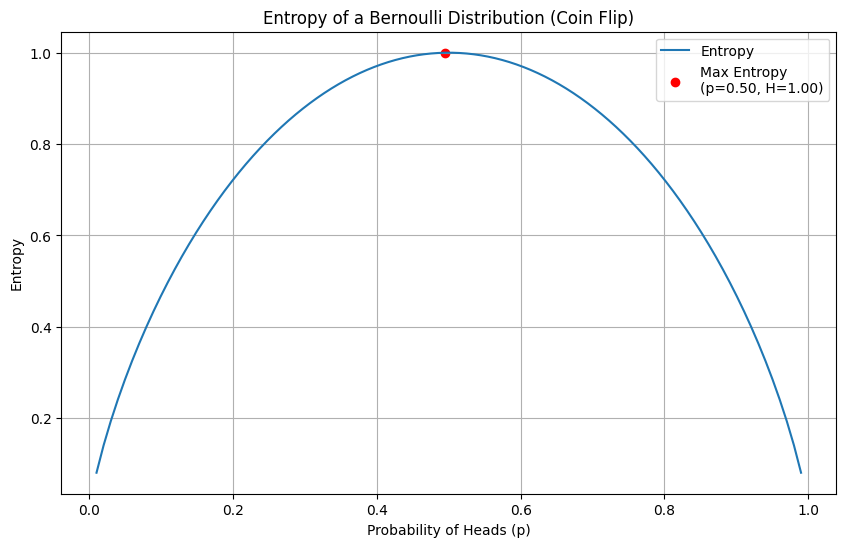

In [8]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    return - p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Generate values of p from 0 to 1
p_values = np.linspace(0.01, 0.99, 100)

# Calculate entropy for each value of p
entropies = [entropy(p) for p in p_values]

# Find the index of the maximum entropy
max_entropy_index = np.argmax(entropies)
max_entropy_p = p_values[max_entropy_index]
max_entropy = entropies[max_entropy_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(p_values, entropies, label='Entropy')
plt.scatter(max_entropy_p, max_entropy, color='red', label=f'Max Entropy\n(p={max_entropy_p:.2f}, H={max_entropy:.2f})')
plt.title('Entropy of a Bernoulli Distribution (Coin Flip)')
plt.xlabel('Probability of Heads (p)')
plt.ylabel('Entropy')
plt.grid(True)
plt.legend()
plt.show();

Simple example showing how the entropy changes as the probability of heads changes. We can see that the entropy is at its highest when the probability is 50%, which means the highest uncertainty or surprise. Furthermore, the entropy is the lowest when probability of heads is either 0% or 100%, which means there is no surprise/uncertainty about the outcome of the random variable. This confirms the intuition I presented earlier in the text.

## 11 Kullback leibler divergence
Used as a distance measure between two probability distributions. Note that it's not actually a measure, because it's not symmetric. KL-divergence is generally defined as

$$D_{\text{KL}}(P||Q) = E_{x \sim P}\left[\log \dfrac{p(x)}{q(x)} \right]$$

And for discrete we have summation, while for continuous we have integral over the expression. This has a similar interpretation as the pointwise mutual information in the previous section, but I like to interpret it as the relative entropy instead, because one can show that KL-divergence is equivalent to the relative entropy between the approximated distribution Q and the true distribution P.

$$
\begin{align}
D_{\text{KL}}(P||Q) 
=& \int_{-\infty}^{\infty} p(x) \log \dfrac{p(x)}{q(x)} \,dx \\
=& E_{x \sim P}\left[ \log \dfrac{p(x)}{q(x)} \right] \\
=& E_{x \sim P}\left[ \log p(x) - \log q(x) \right] \\
=& \{\text{Use } \log \frac{p}{q} = \log p - \log q = -(-\log p) - \log q\} \\
=& E_{x \sim P}\left[ -\log q(x) \right] - E_{x \sim P}\left[ -\log p(x) \right] \\
=& H(P,Q) - H(P)
\end{align}
$$

where $H(P,Q)$ is the cross-entropy, not joint entropy. I will cover this more in section 12.
This shows the relative entropy between Q and P, in a way one could interpret it as how much more information is needed when using the approximated distribution Q instead of the true distribution P, so in a sense it shows inefficiency or redundancy.
Low KL-divergence is what you want, the higher the worse the approximate distribution is.

**Properties**
* Not symmetric meaning $D_{\text{KL}}(P||Q) \neq D_{\text{KL}}(Q||P)$
* Non-negative $D_{\text{KL}}(P||Q) \geq 0$ and it's zero only when $P = Q$
* if q(x) is 0 then $D_{\text{KL}}(P||Q) = \infty$, but if p(x) is zero then regardless of what q(x) is $D_{\text{KL}}(P||Q) = 0$. It just seems to be the way the chose to define it. You can find it [here](https://stats.stackexchange.com/questions/362860/kl-divergence-between-which-distributions-could-be-infinity)

Interestingly enough mutual information can be calculated with KL-divergence in 3 different ways
* $D_{\text{KL}}(P(X,Y)||P(X)P(Y))$, this is the direct definition of mutual information. Gives the interpretation of how different the joint is from if they were independent
* $E_Y[D_{\text{KL}}(P(X|Y)||P(X))]$ 
* $E_X[D_{\text{KL}}(P(Y|X)||P(Y))]$

**Forward vs reverse KL-divergence - What's the difference between $D_{\text{KL}}(P||Q)$ and $D_{\text{KL}}(Q||P)$?**
\
The one I'm used to seeing is called the **forward KL-divergence** where P is the true and Q the approximated distribution to P. Assume we are working with continuous data

$$D_{\text{KL}}(P||Q) = E_P\left[\log \left(\dfrac{P}{Q}\right)\right] = \int_{x \in X} P(x) \log\left[\dfrac{P(x)}{Q(x)} \right] \, dx$$

Minimizing this w.r.t to Q gives a quantity called M-projection short for [Moment projection](https://en.wikipedia.org/wiki/Information_projection). One has to remember that the objective is to minimize the KL-divergence, so we want it as low as possible. The lowest it can get is zero. Also, very important is that Q is the only distribution we can **change**, not the true distribution P. Now if we observe the case that $P(x) > 0$ and $Q(x) = 0$, then for these cases the divergence will go to infinity, because $\dfrac{P}{0}$ is undefined, which is not what we want. However, according to this post [indeterminate form for kl divergence](https://stats.stackexchange.com/questions/362860/kl-divergence-between-which-distributions-could-be-infinity) the situation where $P(x) = 0$ and $Q(x) = 0$ is surprisingly valid even though $\log(0)$ is not defined, instead they've defined the divergence in this situation as 0. Regardless, this means that we cannot construct a distribution Q such that $Q(x) = 0$ and $P(x) > 0$ at the same time and that is the only case. As a consequence of this $Q$ must assign non-zero probabilities to all possible x values that have non-zero probabilities under p as well, that is we need both $Q(x) > 0, P(x) > 0$. By doing this Q is **zero-avoiding** or **mode-covering** P and will therefore distribute probability densities/masses on places of the support of P (x values in P that are non-zero) that might be otherwise very low. It will in other words cover more of the distribution P than needed by overestimating the distribution P. If P is a bimodal (two modals, i.e. two peaks) distribution, then the following image of the contours of P and Q illustrates this phenomenon that I just described

![](assets/mode-covering.png)

Q is covering the entire P distribution, especially both the modes (thus the name), but also outside which has very low probability as it's overestimating the P distribution.

On the other hand for the **reverse KL-divergence** we have

$$D_{\text{KL}}(Q||P) = E_Q\left[\log \left(\dfrac{Q}{P}\right)\right] = \int_{x \in X} Q(x) \log\left[\dfrac{Q(x)}{P(x)} \right] \, dx$$

Minimizing this w.r.t to P is called I-projection short for [Information projection](https://en.wikipedia.org/wiki/Information_projection). Here we don't want the situation where $P(x) = 0$ and $Q(x) > 0$, because that will give infinity. However, unlike the M-projection, having $P(x) > 0$ and $Q(x) = 0$ i.e. assigning zero probabilities to areas in space where P has non-zero probability is not so severe as it doesn't give infinity, in fact it gives zero contribution. We can do this because Q is the distribution we can change. As a result q can exclude all areas (assign zero probability) of space where P is low or $P(x) = 0$ by instead putting all probability density/mass in parts of the support of P that has high probabilities. This behavior is therefore called **mode-seeking** or **zero-forcing** compared to the M-projection. Image below to illustrate this 

![](assets/mode-seeking.png)

**Which one to use $D_{\text{KL}}(P||Q)$ or $D_{\text{KL}}(Q||P)$?**
* Use M-projection $D_{\text{KL}}(P||Q)$ when you need a comprehensive approximation that covers all significant regions of the target distribution, especially important in generative models and variational inference. It's important in generative models because it's usually the case that one wants to generate samples that represent the full diversity of the data.
* Use I-projection $D_{\text{KL}}(Q||P)$ when you want to focus on the most probable regions of the distribution, useful in regularized optimization problems, clustering, and maximum likelihood estimation.

**Intuition KL-divergence**
\
To give intuition on KL-divergence in general here's a good animation I [found](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/)

In [9]:
from IPython.display import Video
Video("assets/KL_Divergence.mp4", width=720, height=540)

They use the blue distribution as the true distribution and the red as the reference. The green is the KL-divergence value. This simply shows how the KL-divergence $D_{\text{KL}}(Q||P)$ behaves as the gaussian distribution is being shifted along the x-axis. Notice that the green values are zero (the KL-divergence is zero) when both the distributions matches perfectly.

## 12 Cross entropy
Cross-entropy is defined as 

$$H_P(Q) = H(P,Q)= E_P[-\log Q] = - E_P[\log Q]$$

And for the discrete and continuous cases we have

$$H(P,Q) = - \sum_{x \in X} P(x) \log Q(x)$$
$$H(P,Q) = - \int_{X} P(x) \log Q(x)$$

Note that the order of P and Q in $H(P,Q) \neq H(Q,P)$ matters since they are not the same. Also, it's unfortunate that they use the same notation for cross-entropy as the joint entropy as that can cause confusion, but remember that these are not the same. That's the reason I wrote $H_P(Q)$ at first to make it clearer that the cross-entropy is just the entropy of the approximated distribution (our model) Q under the true distribution P.

Cross-entropy is a common loss function in DL and the interpretation given by wiki is:
> The cross-entropy between two probability distributions p and q over the same underlying set of events, measures the average number of bits needed to identify 
> an event drawn from the set when the coding scheme used for the set is optimized for an estimated probability distribution q, rather than the true distribution p.

It's a confusing sentence, but I think Murphys description is more understandable:
>the cross entropy is the average number of bits needed to encode data coming from a source with distribution p when we use model q

And the cross-entropy loss is just a measure of how good the model is to approximating (with distribution Q) this true distribution P. It does however sound similar to KL-divergence which is also a measure (not symmetrical) that tells you how good your approximated distribution is to the true distribution. So it sounds like there might be a relation, which there is that can be shown with a simple derivation starting from the definition of cross-entropy

$$
\begin{align}
H(P,Q) 
&= H_P(Q) \\
&= - E_P[\log Q] \\
&= - E_P\left[\log \left(Q \dfrac{P}{P}\right) \right] \\
&= \{\text{Push Q into the numerator and use logarithm laws to separate the P in the numerator from the rest}\} \\
&= - E_P\left[\log \dfrac{Q}{P} + \log P \right] \\
&= - E_P\left[\log \dfrac{Q}{P} \right] - E_P\left[\log P \right] \\
&= D_{\text{KL}}(P || Q) + H(P).
\end{align}
$$

It's clear now that cross-entropy really is just the entropy of the true distribution P plus the KL-divergence between P and Q. Interesingly enough, if H(P) is constant if we are working for instance with a dataset that doesn't change, then minimizing the cross-entropy of P and Q is the same as minimizing the KL-divergence of P and Q.

**Cross-entropy intuition example**

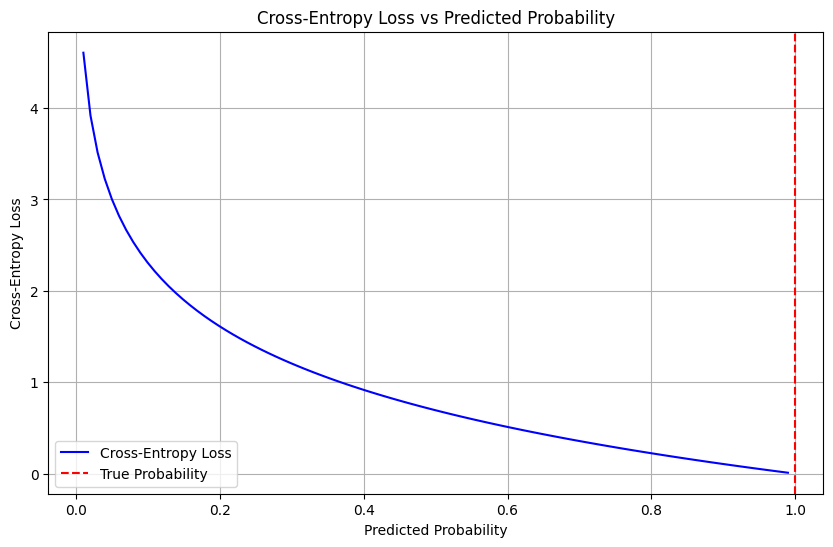

In [10]:
# True probability distribution (for binary classification)
true_prob = 1.0

# Predicted probabilities ranging from 0 to 1
pred_probs = np.linspace(0.01, 0.99, 100)

# Cross-entropy loss calculation
cross_entropy_loss = - (true_prob * np.log(pred_probs) + (1 - true_prob) * np.log(1 - pred_probs))

# Plotting the cross-entropy loss
plt.figure(figsize=(10, 6))
plt.plot(pred_probs, cross_entropy_loss, label='Cross-Entropy Loss', color='b')
plt.axvline(true_prob, color='r', linestyle='--', label='True Probability')
plt.title('Cross-Entropy Loss vs Predicted Probability')
plt.xlabel('Predicted Probability')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show();

This just shows how the cross-entropy varies when the approximated distribution (predicted probability) gets closer and closer to the true distribution. At 1 we will get a zero loss, because then the predicted distribution is the same as the true distribution.

**Cross-entropy the same as negative log-likelihood**
Under the constraint of classification tasks minimizing the cross-entropy is the same as minimizing the negative log-likelihood. We can see that they compute the same quantity in classification task. Note however that in general they are not the same. 

In [11]:
def cross_entropy(y_hat, y):
    ce = -np.log(y_hat[range(len(y_hat)), y])
    return ce.mean()

labels = torch.tensor([0, 2])
preds = torch.tensor([[0.3, 0.6, 0.1], [0.2, 0.3, 0.5]])

cross_entropy_loss = cross_entropy(preds, labels)

nll_loss = NLLLoss()
negative_log_likelihood_loss = nll_loss(torch.log(preds), labels)

assert cross_entropy_loss == negative_log_likelihood_loss

print(f"Cross-entropy loss: {cross_entropy_loss: .4f}")
print(f"Negative log-likelihood loss: {negative_log_likelihood_loss: .4f}")

Cross-entropy loss:  0.9486
Negative log-likelihood loss:  0.9486


## 13 Difference between kl divergence and cross entropy
Even though they seemingly measure the same thing, that is how good the approximated distribution is to the true distribution, they are not the same as can be seen by their formulas.

$$H(P,Q) = D_{\text{KL}}(P || Q) + H(P)$$
$$D_{\text{KL}}(P||Q) = H(P,Q) - H(P)$$

The formulas presented is kind of a circular argument, but I think it highlights the difference, which is that cross-entropy includes the intrinsic entropy of P plus the KL divergence, whereas the KL divergence represents just the inefficiency of using Q to approximate P.

## 14 Evidence lower bound
ELBO stands for evidence lower bound but is sometimes called variational lower bound because you can change it so it varies. The idea is you have some data you want to model say $P(X)$, which is called evidence because it's the marginal in the denominator in a bayes' theorem. The lower bound part comes from the fact that we can't model our data directly since it's a very complicated distribution and usually is intractable, so we need to approximate it, and people have found that one way you can do it is by finding a lower bound for the marginal of the data $P(X)$. That lower bound will in some way be tractable for our model. The idea of a lower bound is very simple, you have a function $f(X) \leq P(X)$ that's always lower or equal to the evidence data and so $f(X)$ is therefore lower bound to $P(X)$ in this case. However, the challenge lies in finding that lower bound, which can be difficult. ELBO usually appears in [expectation maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) and [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) among other things. I will just present a simple example of a situation with ELBO and show how it can be derived, but remember that ELBO can have [different forms](https://en.wikipedia.org/wiki/Evidence_lower_bound#Main_forms) and so it depends on the task at hand and what data one has access to. Additionally, I will also show the derivation of ELBO for diffusion models. However, before that I will show a simple example of a lower bound, a function that is always equal or less than another function

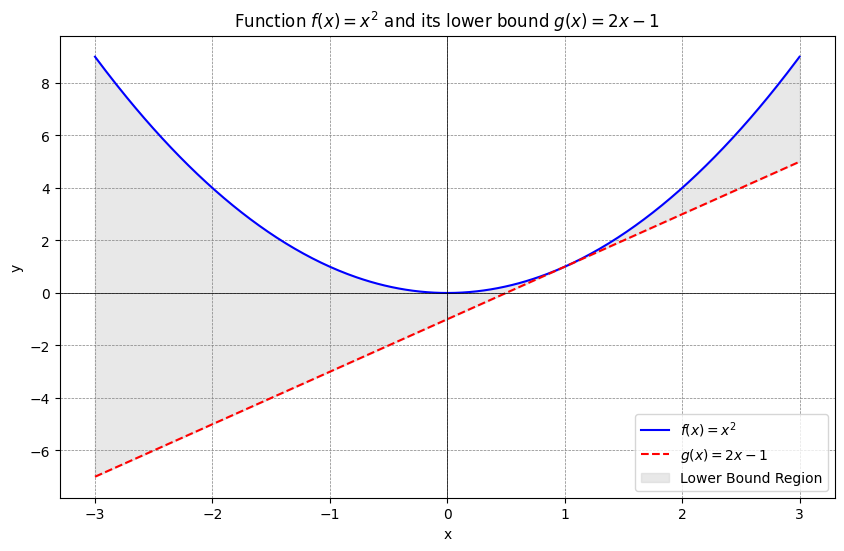

In [12]:
# Define the functions
def f(x):
    return x**2

def g(x):
    return 2*x - 1

# Generate x values
x = np.linspace(-3, 3, 400)

# Calculate y values for each function
y_f = f(x)
y_g = g(x)

# Plot the functions
plt.figure(figsize=(10, 6))
plt.plot(x, y_f, label='$f(x) = x^2$', color='blue')
plt.plot(x, y_g, label='$g(x) = 2x - 1$', color='red', linestyle='dashed')

# Highlight the lower bound region
plt.fill_between(x, y_g, y_f, where=(y_g <= y_f), color='lightgray', alpha=0.5, label='Lower Bound Region')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function $f(x) = x^2$ and its lower bound $g(x) = 2x - 1$')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

# Show the plot
plt.show();

As you can see the red line is clearly always lower than or equal to the blue line, which makes $g(x) \leq f(x)$, so $g$ is a lower bound to $f$. Now on to our examples.

**Simple ELBO example**
\
This example is taken from [Gundersen](https://gregorygundersen.com/blog/2021/04/16/variational-inference/) and I like it because it shows very clearly how the ELBO is derived for an easy example. At it's core it's from a variational inference setting, which I will explain more of in the next section. Therefore, for the sake of explaining ELBO I will only cover the terms involved. Let's assume we have data X and latent variables Z. We want to do bayesian inference and need $P(Z|X)$ but according to bayes' theorem we also need the marginal $P(X)$ to normalize the joint $P(X,Z)$. This marginal is intractable, because the variable Z might be high dimensional (lots of latent variables). What we can do instead is to use a model to approximate the true distribution $P(Z|X)$ via KL-divergence and turn this into a minimization problem, where we minimize the KL-divergence

$$
\begin{align}
D_{\text{KL}}(Q(Z)||P(Z|X)) 
&= \int_Q Q(Z) \log \dfrac{Q(Z)}{P(Z|X)} \\
&= E_Q\left[\log \dfrac{Q(Z)}{P(Z|X)} \right] \\
&= E_Q\left[\log \dfrac{Q(Z)P(X)}{P(Z|X)P(X)} \right] \\
&= E_Q\left[\log \left(\dfrac{Q(Z)}{P(Z,X)}P(X)\right) \right] \\
&= E_Q\left[\log \left(\dfrac{Q(Z)}{P(Z,X)}\right) + \log P(X) \right] \\
&= E_Q\left[\log Q(Z) - \log P(Z,X)\right] + E_Q\left[\log P(X) \right] \\
&= \underbrace{E_Q\left[\log Q(Z) - \log P(Z,X)\right]}_{\text{-ELBO(Q)}} + \log P(X) \\
\end{align}
$$

where ELBO is

$$ELBO(Q) = E_Q\left[\log P(Z,X) - \log Q(Z)\right]$$

Now moving the log marginal to one side we can show why ELBO is a lower bound to the log marginal $\log P(X)$

$$\log P(X) = ELBO(Q) + D_{\text{KL}}(Q(Z)||P(Z|X))$$

There are a few things to note, most importantly the KL-divergence is non-negative, meaning that it will never be negative, and that $\log P(X)$ is a constant because it's just the data we have which doesn't change. Our objective is to minimize the KL divergence, but as a consequence of this, because $\log P(X)$ is a constant, we will also be maximizing the ELBO. Another way to see this is to move ELBO to the same side as the log marginal

$$\log P(X) - ELBO(Q) = D_{\text{KL}}(Q(Z)||P(Z|X)).$$

Now because log marginal is constant and KL-divergence cannot be negative it means that the only way to **minimize** the KL-divergence is to **maximize** $ELBO(Q)$. Ideally when $\log P(X) = ELBO(Q)$ then the KL-divergence will be zero, meaning that the two distributions $Q(Z)$ and $P(Z|X)$ will be the same. In reality there will always be a gap between the two as we are never that lucky and as a consequence there will also be a gap between the log marginal and the ELBO. In theory however, they can still be the same thus we have the inequality $\log P(X) \geq ELBO(Q)$ and this is just the evidence lower bound that we wanted to show.

So in conclusion this is wonderful, we wanted to work with $P(Z|X)$, but couldn't because the marginal $P(X)$ was intractable. We instead chose a model $Q(Z)$ to approximate $P(Z|X)$ and used KL-divergence as our objective to minimize. Through simple algebraic manipulations we extracted the ELBO and showed that we can actually work with the intractable term $P(X)$ indirectly by maximizing the ELBO, which minimizes the KL-divergence between our model $Q(Z)$ and the true distribution $P(Z|X)$. And that's pretty much it. However, note that there is a very important insight here that greatly benefits generative models if we were interested in sampling from $P(X)$, which is that we can also learn this distribution $P(X)$ indirectly through the ELBO. This is because maximizing the ELBO makes the model approach the log marginal closer and closer, and when properly optimized should create a model that produces samples that reflect the true distribution $P(X)$ well.

**Diffusion model ELBO derivation**
\
Now on to diffusion models. Once again we want to learn $P(X)$, where X is our data, so we can sample images from it, but this term is a very complicated multimodal probability distribution. What we do instead is turn to Bayes' theorem to find the necessary components. Usually one extracts the conditional probability out of Bayes' theorem, but it's possible to express it as the marginal instead

$$
P(Z|X) = \dfrac{P(X,Z)}{P(X)} \implies P(X) = \dfrac{P(X,Z)}{P(Z|X)}
$$

We use a model $Q_{\phi}(Z|X)$ to approximate $P(Z|X)$, where $\phi$ is the model parameter. Now starting from the marginal we can derive the ELBO very easily with some tricks

$$
\begin{align}
\log P(X)
&= \left\{\text{Multiply by } 1 = \int_{z \in Z} Q_{\phi}(z|x) \, dz\right\} \\
&= \log P(X) \int_{z \in Z} Q_{\phi}(z|x) \, dz \\
&= \int_{z \in Z} Q_{\phi}(z|x) \log P(x)  \, dz \\
&= E_{Q_{\phi}(z|x)}\left[\log P(x) \right] \\
&= \left\{P(x) = \dfrac{P(x,z)}{P(z|x)} \right\} \\
&= E_{Q_{\phi}(z|x)}\left[\log \dfrac{P(x,z)}{P(z|x)} \right] \\
&= E_{Q_{\phi}(z|x)}\left[\log \dfrac{P(x,z)Q_{\phi}(z|x)}{P(z|x)Q_{\phi}(z|x)} \right] \\
&= E_{Q_{\phi}(z|x)}\left[\log \dfrac{P(x,z)}{Q_{\phi}(z|x)} \right] + E_{Q_{\phi}(z|x)}\left[\log \dfrac{Q_{\phi}(z|x)}{P(z|x)} \right] \\
&= E_{Q_{\phi}(z|x)}\left[\log \dfrac{P(x,z)}{Q_{\phi}(z|x)} \right] + D_{\text{KL}}(Q_{\phi}(z|x)||P(z|x)) \\
&\geq E_{Q_{\phi}(z|x)}\left[\log \dfrac{P(x,z)}{Q_{\phi}(z|x)} \right]
\end{align}
$$

where we can see that the last equation is the ELBO. What's interesting here is to note that the log marginal $P(X)$ is just the KL divergence added with the ELBO, similar to the situation we had with the simple example previously! This means that we can draw the same conclusions as in that case, that maximizing the ELBO will minimize the KL divergence because the log marginal is constant and in this case doesn't depend on the model parameters $\phi$. As a result a properly optimized ELBO should create a model that can produce samples reflective of the marginal $P(X)$, which is what we want.

## 15 Variational inference


## 16 Langevin sampling


## 17 Mixture of gaussians
Mixture of gaussians is just a weighted sum of gaussians, with each of their own parameters. To demonstrate the power of gaussian mixture models (gmm) let's look at data collected from a geyser activity in Yellowstone

![](assets/gaussian_vs_gmm.png)

x-axis is duration in minutes for an erruption and y-axis is minutes until next erruption. These are contour plots of the gaussian distributions. Blue dots are the data. Here we can see the limitations of a gaussian distribution that is only unimodal, simply because the data is distributed in a way that an unimodal gaussian would not be able to capture, since the peak in the middle (the very middle part of the gaussian distribution) is not representative of the peaks that otherwise would be on the very clustered areas (with lots of blue dots). However, a gmm is perfectly capable of capturing this distribution as it looks like there are two different gaussian distributions laying over the data with peaks at the right areas. Another one to show the intuition of combining gaussians is this 1D example

![](assets/gmm_sum_gaussian.png)

here we have 3 unimodal gaussians that represents the blue curves and the red is the gmm that is a weighted sum of the three gaussians. It's interesting to see that the gmm is almost a perfect merge of the three gaussians, although in general that doesn't have to be the case. For a 2D case where we merge 3 different gaussians we have

![](assets/gmm_examples.png)

where a) shows the 3 gaussians, b) the gmm of the three with some weighting and this looks almost exactly like a merged version of the previous one and c) the 3D plot of the gmm. 
Anyways, enough with examples let's define gmm

$$P(x) = \sum_{k \in K} \pi_k \mathcal{N}(x|\mu_k, \Sigma_k) $$

where $\pi_k$ is the weighting of distribution k, i.e. the higher weighting the more important it is and therefore will have more influence on the appearance of the gmm. Also, $\pi_k$ has to fulfill $\sum_k \pi_k = 1$. Another constraint is that the covariance matrix has to be positive semi-definite meaning given a column vector x we have the relation $x^T\Sigma_k x \geq 0$. To set the parameters one could perform MLE on the log likelihood of the data

$$\log P(X|\theta) = \sum_{n=1}^{N}\log\left[\sum_{k=1}^{K} \pi_k \mathcal{N}(x_n|\mu_k, \Sigma_k) \right]$$

where $\theta = \{\pi,\mu,\Sigma\}$. Bishop notes that taking the derivative of the term inside log and setting it to zero doesn't have a closed-form, so we can't directly solve the MLE. One way to do remedy this is to use EM short for expectation maximization, which will be covered in the next section. One last thing for this section is one might note that the above equation can be interpreted as a marginalization of the gmms, prince provides a nice illustration of this. If we assume that we instead introduce hidden variables that we marginalize out to get the marginal of the data then we have the same situation as above, but we can relate the terms to the hidden variables h. If we assume the weighting terms are categorically distributed, because that's what they are and the conditional $P(x|h,\theta)$ is multivariate normally distributed 

$$P(x|h,\theta) = \mathcal{N}[\mu_h, \Sigma_h]$$ 
$$P(h|\theta) = Cat_{h}[\mathbb{\lambda}]$$ 

then we can relate the gmm in the marginal equation above to the following equation

$$
\begin{align}
P(x|\theta) 
&= \sum_{k=1}^{K} P(x, h=k|\theta) \\
&= \sum_{k=1}^{K} P(h=k|\theta)P(x| h=k,\theta) \\
&= \sum_{k=1}^{K} \lambda_k \mathcal{N}[\mu_k, \Sigma_k]. \\
\end{align}
$$

Here we can see that the weighting is represented by the density of $\lambda_k$ and the gaussian distributions are the density of the data given the hidden variables $P(x|h=k, \theta)$. It also has a nice interpretation, in order to sample x from the joint we basically start by sampling the hidden variable h and then given that hidden variable we sample x from the gaussian distribution. Because sampling x from the gaussian distribution is conditioned on the hidden variable h we can interpret the hidden variable as assigning how much the gaussian distribution is responsible for the generating the sampled x. Furthermore, by adding up this contribution of all distributions and thus marginalizing out the hidden variables we get the overall likelihood of sampling that specific datapoint x. Two illustrations by Prince makes this very clear

![](assets/gmm_marginal.png)
![](assets/gmm_responsibility.png)

First one shows the process of marginalizing out all the hidden variables from the joint $P(x,h)$ to produce the marginal $P(x)$, which is just a weighted sum of all the gaussian distributions where we have taking into account all of their contribution to produce the data x. Second image illustrates the idea of the weighting constituting the responsibility each gaussian distribution has on each datapoint x being sampled from it. For the binary case for $P(h|x=x_1)$ we can see in the example that distribution $k=1$ has a bigger responsibility (weighting) on generating the sampled datapoint (purple) than distribution $k=2$, as can be also clearly seen in their probability distribution where red has higher probability than green for the purple datapoint. As a result of this, the first distribution will have a bigger influence on the appearance of the marginal $P(x)$ at that specific datapoint.  

## 18 Expectation maximization
The point of EM is to estimate model parameters from some statistical model when we have observed data where the model depends on some hidden variables. EM is iterative and finds (local) MLE or MAP, and because as we saw in the previous section doing MLE on the gaussian mixture model for instance didn't yield any closed-form solutions EM can instead solve this problem iteratively. EM alternates between two steps
1. Expectation step called E-step, where it finds the maximum lower bound with fixed model parameters $\theta$  
2. Maximization step called M-step, here it tries to find the best model parameters $\theta$ with the given fixed distribution of the responsibilities (that is the distribution of the hidden variables).

Before going into the high-level details (sadly without proof) of the steps I will show an example of the evolution of the EM method taken from Prince

![](assets/em_steps.png)

This shows a very nice iterative evolution of how the distributions (gaussian in this case) progressively adapts to the datapoints, very similar to clustering methods, at the end we have a well-trained model that can capture the two different classes in the data. Notice how the E-step and M-step alternates between each other starting with an initialization of the model distributions and the E-step.

Our general objective with the EM algorithm is to solve 

$$\theta_{\text{opt}} = \underset{\theta}{\operatorname{argmax}}\left[\sum_{i=1}^{I} \log \left[\int P(x_i, h_i | \theta)\, dh_i \right] \right]$$

And because once again this doesn't have a closed from solution for the MAP or MLE, then we make use of a lower bound that Prince calls beta 

$$
\begin{align}
\beta[\{q_i(h_i)\}, \theta] 
&= \sum_{i=1}^{I}\int q_i(h_i) \log\left[\dfrac{P(x_i,h_i|\theta)}{q_i(h_i)}\right] \, dh_i \\
&\leq \sum_{i=1}^{I}\log\left[\int P(x_i, h_i|\theta)\, dh_i \right]
\end{align}
$$

$\{q_i(h_i)\}$ contains a set of probability distributions of the responsibilities. The number of distributions q is just the number of hidden variables, which seems to be determined by the number of datapoints. The idea for the lower bound is when you vary the probability distributions of the responsibility the lower bound will change as a result, but because it's a lower bound it will never exceed the marginal probability of the data $P(x|\theta)$.

Furthermore, one can show that the best responsibility distribution (distribution of hidden variable) is given by

$$q_{\text{opt}}(h_i) = P(h_i | x_i, \theta) = \dfrac{P(x_i|h_i,\theta^{[t]})P(h_i|\theta^{[t]})}{P(x_i)}$$ 

The proof for the lower bound and the best responsibility for a given distribution and datapoint can be found in the book [Computer Vision:  Models, Learning, and Inference by Simon J.D. Prince](http://www.computervisionmodels.com/). I will refer all the proofs to the book.

I think it's instructive to explain the EM algorithm for a simple example, such as a gmm.

**E-step**
\
In the E-step we want to construct a distribution that sort of spreads out the probabilities in the form of responsibilities to indicate the distributions (in our model) that are most responsible for the occurrence of a given datapoint. So the distribution that are more responsible for a generating a datapoint should ideally have higher probability density in the responsibility distribution. And using the insight above about how to find the best responsibility distribution we get for a gmm using bayes' theorem (Prince proves why the posterior distribution is the best one)

$$
\begin{align}
q_i(h_i) 
&= P(h_i=k|x_i, \theta^{[t]}) \\
&= \dfrac{P(x_i|h_i=k, \theta^{[t]})P(h_i=k, \theta^{[t]})}{\sum_{j=1}^{K}P(x_i|h_i=j, \theta^{[t]})P(h_i=j, \theta^{[t]})} \\
&= \{\text{Remember responsibilities are categorically distributed and the data conditioned on responsibility is gaussian}\} \\
&= \dfrac{\lambda_k \mathcal{N}[x_i| \mu_k, \Sigma_k]}{\sum_{j=1}^{K}\lambda_j \mathcal{N}[x_i| \mu_j, \Sigma_j]} \\
&= r_{ik}.
\end{align}
$$

where we have $\theta = \{\lambda_k, \mu_k, \Sigma_k\}_{k=1}^{K}$ and $P(h_i=k|x_i, \theta^{[t]})$ constitutes the probability that the kth gaussian distribution generated the ith datapoint, which is why it's denoted as $r_{ik}$. This is the expectation step, you are basically just computing the responsibility distribution for each hidden variable $h_i$ using bayes' theorem. This responsibility distribution is fixed in the M-step. Note that computing the responsibility distribution $r_{ik}$ has the effect of maximizing the lower bound, while the model parameters $\theta$ are fixed. Below is an illustration showing this clearly

![](assets/e_step.png)

The log likelihood is the likelihood of the marginal $P(x)$ of the data. And the green curve is the lower bound that is being maximized. Once again notice how the parameters $\theta$ are fixed, so it's only the lower bound that is changing.

**M-step**
\
In the M-step we shift focus to find the optimal model parameters $\theta$ using the responsibility distribution we computed in the E-step. The responsibilities are fixed $r_{ik}$.

$$
\begin{align}
\Theta_{opt}^{t+1} 
&= \underset{\theta}{\operatorname{argmax}}\left[\sum_{i=1}{I}q_i(h_i = k) \log[P(x_i, h_i=k | \theta)] \right] \\
&= \underset{\theta}{\operatorname{argmax}}\left[\sum_{i=1}{I}r_{ik} \log[\lambda_k \mathcal{N_{x_i}[\mu_k, \Sigma_k]}] \right]
\end{align}
$$

Taking the derivative of this expression, setting it to zero and using something like [lagrange multiplier method](https://en.wikipedia.org/wiki/Lagrange_multiplier#) to respect the constraints of $\sum_k \lambda_k = 1$ gives the update rules

$$\lambda_k^{[t+1]} = \dfrac{\sum_{i=1}^{I}r_{ik}}{\sum_{j=1}^{K}\sum_{I}^{i=1}r_{ij}}$$
$$\mu_k^{[t+1]} = \dfrac{\sum_{i=1}^{I}r_{ik}x_i}{\sum_{I}^{i=1}r_{ik}}$$
$$\Sigma_k^{[t+1]} = \dfrac{\sum_{i=1}^{I}r_{ik}(x_i - \mu_k^{[t+1]})(x_i - \mu_k^{[t+1]})^T}{\sum_{I}^{i=1}r_{ik}}$$

These update rules luckily have an easy interpretation. $\lambda_k$ just means updating the kth $\lambda_k$ by the relative total responsiblity. $\mu_k$ constitutes the weighted mean of over the data, where the weights are the responsibilities. $\Sigma_k$ has a similar interpretation according to Prince. To illustrate how the M-step works here's an image

![](assets/m_step.png)

Here we can see that the lower bound is fixed while the parameter is changing moving towards the optimum point of the lower bound curve.

\
As already mentioned the E- and M-step are alternated during the iterations until the lower bound stops improving in the E-step and the parameters don't improve in the M-step. That means convergence has been reached. Prince has another good image illustrating the process of EM in a graph

![](assets/em_progression_graph.png)

This is basically just the graph put together from the E- and M-step.

Before showing coding examples of using EM on gmm, two things should be mentioned. Firstly, the initialization affects the final trained parameters, leading to different appearances of the distributions. Here's an image of this by Prince fitting mixture of gaussians with EM.

![](assets/init_gmm_em.png)

So we can see the effect of EM only being able to find local maximums leading to different converges of final distributions when the initializations are different. It's not too different for these toy examples, but it might be bigger for more and harder data. Secondly, the choosing the number of gaussians components in the mixture model is a hyperparameter that needs to be pre-specified by the user is also not something EM finds for you. This means some other techniques needs to be utilized in order to find an optimal number. Now we will move on to examples taken from one of my previous courses, as I found it really instructive I will not change any of the code and present it here as is.

**Code example**
\
Generate data samples from multiple multivariate gaussians

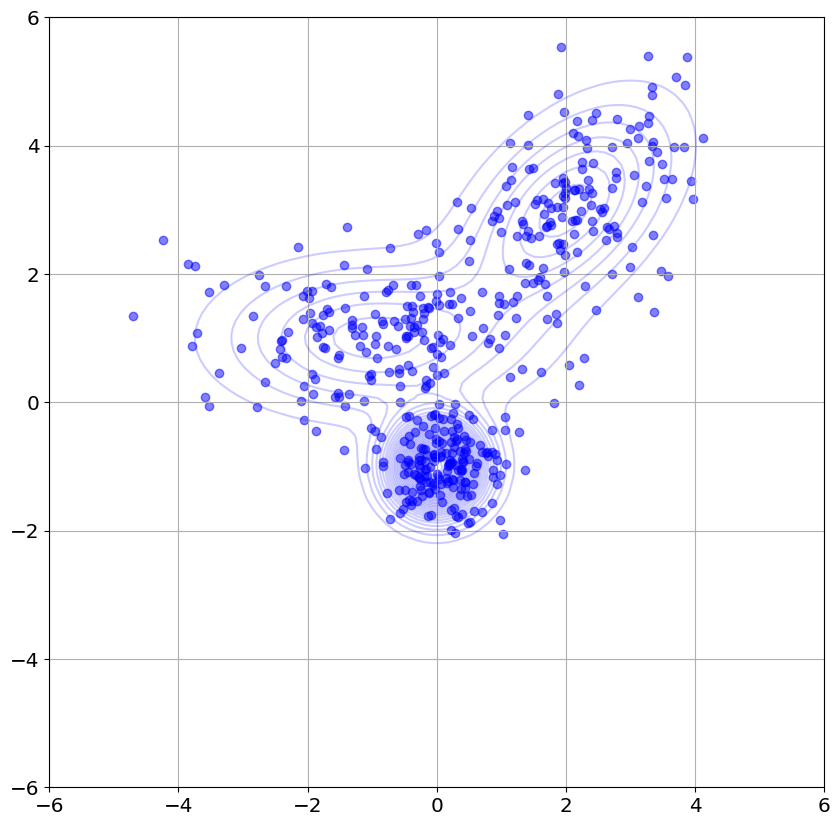

In [14]:
N = 500
pi = [0.33,0.33,0.34]
K = len(pi)
param_muA1 = [2,3]; param_muA2 = [-1,1]; param_muA3 = [0,-1];
param_CA1 = np.array([[1,0.5],[0.5,1]]); param_CA2 = np.array([[2,0],[0,0.5]])
param_CA3 = np.array([[1,0],[0,1]])/5



GMMA = mixture.GaussianMixture(K)
GMMA.fit(np.random.uniform(size=[N,2])) # this is just to instantiate the object in R2
GMMA.weights_ = pi
GMMA.means_ = np.array([param_muA1, param_muA2,param_muA3])
GMMA.covariances_ = np.array([param_CA1, param_CA2,param_CA3])
ZA = GMMA.sample(N)

xx, yy = np.meshgrid(np.linspace(-6,6,100), np.linspace(-6,6,100))
points = np.stack((xx, yy), axis=-1)
pdfA1_true = scipy.stats.multivariate_normal.pdf(points, param_muA1, param_CA1)
pdfA2_true = scipy.stats.multivariate_normal.pdf(points, param_muA2, param_CA2)
pdfA3_true = scipy.stats.multivariate_normal.pdf(points, param_muA3, param_CA3)

import matplotlib.pyplot as plt
# The following makes the plot look nice
params = {'legend.fontsize': 'x-large','figure.figsize': (10, 10),
          'axes.labelsize': 'x-large','axes.titlesize':'x-large',
          'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure(); ax = fig.add_subplot(111)
ax.scatter(ZA[0][:,0],ZA[0][:,1],alpha=0.5,c='blue')
ax.contour(xx, yy, GMMA.weights_[0]*pdfA1_true+GMMA.weights_[1]*pdfA2_true+GMMA.weights_[2]*pdfA3_true,
           levels=40, colors='blue', alpha=0.2)
plt.grid()
plt.show();

Just data sampled from multiple multivariate gaussians. Next up we fit a gmm with 3 multivariate gaussians to the data with EM.

Initialization 0
Initialization converged.
Initialization 1
Initialization converged.
Initialization 2
Initialization converged.
Initialization 3
Initialization converged.
Initialization 4
Initialization converged.
Mixture weights: [0.35642419 0.31112712 0.33244869] True: [0.33, 0.33, 0.34]


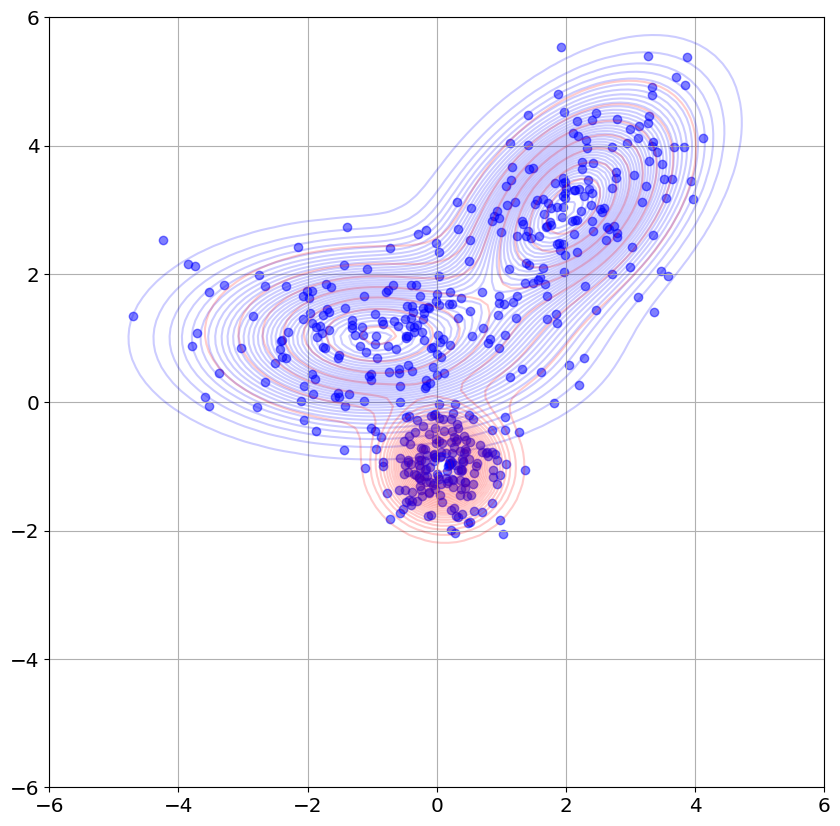

In [17]:
K = 3
GMMA_hat = mixture.GaussianMixture(K,covariance_type='full',verbose=1,
                                   n_init=5,init_params='kmeans',warm_start=True)
GMMA_hat.fit(ZA[0])
print('Mixture weights:',GMMA_hat.weights_,'True:',pi)

fig = plt.figure(); ax = fig.add_subplot(111)
ax.scatter(ZA[0][:,0],ZA[0][:,1],alpha=0.5,c='blue')
xx, yy = np.meshgrid(np.linspace(-6,6,100), np.linspace(-6,6,100))
points = np.stack((xx, yy), axis=-1)
ax.contour(xx, yy, GMMA.weights_[0]*pdfA1_true+GMMA.weights_[1]*pdfA2_true,
           levels=40, colors='blue', alpha=0.2)
pdf_hat = []

for kk in range(K):
    if len(GMMA_hat.covariances_.shape) == 2:
        pdf_hat.append(GMMA_hat.weights_[kk]*
                       scipy.stats.multivariate_normal.pdf(points, GMMA_hat.means_[kk], GMMA_hat.covariances_[0]))
    else:
        pdf_hat.append(GMMA_hat.weights_[kk]*
                       scipy.stats.multivariate_normal.pdf(points, GMMA_hat.means_[kk], GMMA_hat.covariances_[kk]))
sumpdf_hat = np.array(pdf_hat).sum(axis=0)
ax.contour(xx, yy, sumpdf_hat,
           levels=40, colors='red', alpha=0.2)
plt.grid()
plt.show();

**Different metrics to find model fit of gmm**
\
Below is just simple code of how to find model fit of gmms. We use log-likelihood (LL), Akaike information criterion (AIC) and Bayes information criterion (BIC). The idea is the **elbow** is where the optimal number of components lies.

**LL - log likelihood**
\
We can compute the negative log likelihood of the training set given $\Theta$. 

$$\begin{align}L_\mathcal{D}(\Theta)  = -\log P[\mathcal{D}|\Theta] & = -\log \prod_{n=1}^N f_\mathbf{X|\Theta}(\mathbf{x}_n|\Theta)\\
& = -\sum_{n=1}^N \log f_\mathbf{X|\Theta}(\mathbf{x}_n|\Theta)\end{align}$$
assuming all observations are iid.

If our model is quite far from our data, we expect this value to be large.

Thus, we can compute $L_\mathcal{D}(\Theta)$ for several $K$ and select the order based on this.

**Akaike information criterion**
\
Another measure is the Akaike information criterion (AIC), which considers the number of model parameters $M$:

$$AIC(M) = 2M-2\log \prod_{n=1}^N f_\mathbf{X|\Theta}(\mathbf{x}_n|\Theta)$$

**Bayes information criterion**
\
Yet another measure is the Bayes information criterion (BIC), which also considers the number of observations $N$:

$$BIC(M) = M\log(N) - 2\log \prod_{n=1}^N f_\mathbf{X|\theta_i}(\mathbf{x}_n|\theta_i)$$

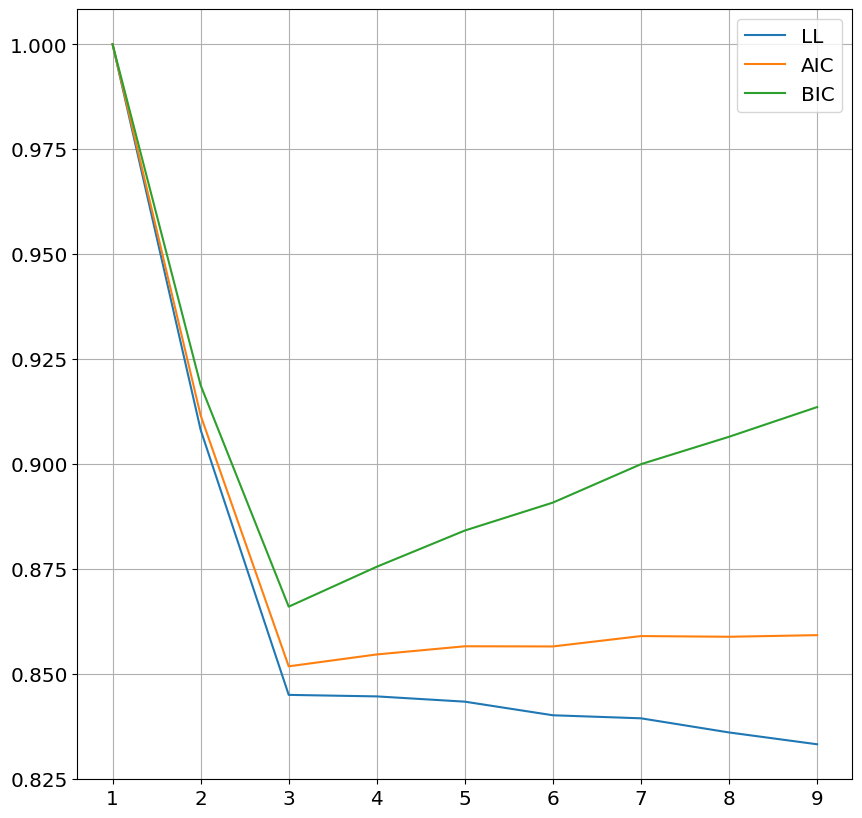

In [18]:
llvals = []
aic = []
bic = []
KK = range(1,10)
for kk in KK:
    GMMA_hat = mixture.GaussianMixture(kk,covariance_type='full',verbose=0,
                                       n_init=5,init_params='kmeans',warm_start=False)
    GMMA_hat.fit(ZA[0])
    llvals.append(-np.sum(GMMA_hat.score_samples(ZA[0])))
    aic.append(GMMA_hat.aic(ZA[0]))
    bic.append(GMMA_hat.bic(ZA[0]))


fig = plt.figure(); ax = fig.add_subplot(111)
plt.plot(KK,llvals/np.max(llvals),label='LL')
plt.plot(KK,aic/np.max(aic),label='AIC')
plt.plot(KK,bic/np.max(bic),label='BIC')
plt.legend()
plt.grid() 
plt.draw();

Here we can see that for all of the metrics the elbow lies on 3, so the optimal number of components for the given gmm and data is 3.

## 19 Bias and variance tradeoff
Bias and variance are defined as

$$Bias_D[\hat{f}(x; D)] = E_D[\hat{f}(x;D) - f(x)]$$
$$Var_D[\hat{f}(x;D) = E_D[(E_D[\hat{f}(x;D)] - \hat{f}(x;D))^2]]$$

To get an intuition on bias and variance we consider a dart analogy, where the middle point is where we want the data to be ideally, i.e. low variance and low bias.

![](assets/bias_variance_dart.png)

High variance means more **spread** of the data from the true mean of the data (our middle point). High bias just means big average **error** between predicted data and true data. Furthermore looking at the bias-variance tradeoff is I think the most useful takeaway of the phenomena, which holds more weight for machine learning than deep learning nowadays, but it can still occur in deep learning.

![](assets/bias_variance_tradeoff.png)

Starting off the bias is usually high as the model is nowhere near converging in training so the error is expected to be bigger at the start. As the model trains if done properly, the bias tends to go down as the model is more accurate with its predictions. However, the model is fitting to the data more and more as more training is done, meaning that the variance of its predictions is going to get bigger. Then at some point comes the point of perfect fit where we the error is as low as possible while holding the bias and variance to a healthy degree. If we move further away from this point, meaning we continue training the model on the data, overfit will eventually happen where bias is low but variance is high. This hurts generalization as the model is highly fit to the given data, but can't generalize to other data as well. That's the gist of the problem. So training the model is about finding that sweet spot between bias and variance.

There's a nice proof of the decomposition of the bias and variance tradeoff on [wiki](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation) of which I will spare the details.
 